In [67]:
from hye_project.my_package.stat_file import test_normality, print_normality, stat_test, outlier

In [65]:
import hye_project.my_package.stat_file as sf
print(dir(sf))

['Any', 'Dict', 'Tuple', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'combinations', 'levene', 'np', 'nx', 'outlier', 'pd', 'plt', 'print_normality', 'sch', 'sm', 'sns', 'sp', 'squareform', 'stat_test', 'stats', 'tabulate', 'test_normality']


In [68]:
# -------
# library
# -------

# Standard library
from itertools import combinations

# Typing
from typing import Any, Dict, Tuple, Union

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reporting
from tabulate import tabulate

# Statistical analysis
import scipy.stats as stats
from scipy.stats import levene
from scipy.spatial.distance import squareform

# Clustering
import scipy.cluster.hierarchy as sch

# Post-hoc tests
import scikit_posthocs as sp

# Modeling
import statsmodels.api as sm

# Network analysis
import networkx as nx

In [69]:
# ---------------------------
# 전처리를 완료한 csv 파일 불러오기
# ---------------------------
df = pd.read_csv('/jiwon_project/csv_files/preprocessing_filtered.csv')

In [54]:
# ----------------------------
# price 컬럼 정규성 및 분포 확인하기
# ----------------------------
# 1. price 컬럼 정규성 검정 결과
price_normality = test_normality(df['price'])

| 검정항목                | 통계량        | p-값 / 임계값   | 판정   |
|-------------------------|---------------|-----------------|--------|
| Skew (왜도)             | 24.421        | -               | -      |
| Excess Kurtosis (첨도)  | 893.551       | -               | -      |
| Shapiro-Wilk            | 0.238         | p=0.000         | Reject |
| D’Agostino K²           | 53264.039     | p=0.000         | Reject |
| Jarque–Bera             | 744028276.333 | p=0.000         | Reject |
| Lilliefors KS           | 0.331         | p=0.001         | Reject |
| Anderson–Darling @15.0% | 3866.117      | crit=0.576      | Reject |
| Anderson–Darling @10.0% | 3866.117      | crit=0.656      | Reject |
| Anderson–Darling @5.0%  | 3866.117      | crit=0.787      | Reject |
| Anderson–Darling @2.5%  | 3866.117      | crit=0.918      | Reject |
| Anderson–Darling @1.0%  | 3866.117      | crit=1.092      | Reject |
| Practical Normal        | -             | -               | False  |


In [72]:

# -------
# library
# -------

# Standard library
from itertools import combinations

# Typing
from typing import Any, Dict, Tuple, Union

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Reporting
from tabulate import tabulate

# Statistical analysis
import scipy.stats as stats
from scipy.stats import levene
from scipy.spatial.distance import squareform

# Clustering
import scipy.cluster.hierarchy as sch

# Post-hoc tests
import scikit_posthocs as sp

# Modeling
import statsmodels.api as sm

# Network analysis
import networkx as nx

# ------------------------------
# 전처리를 완료한 csv 파일 불러오기
# ------------------------------
df = pd.read_csv('/jiwon_project/csv_files/preprocessing_filtered.csv')

# ------------------------------
# 이상치를 정의할 기준 컬럼 찾기
# 2) room_structure_type price의 연관성
# ------------------------------
X2 = 'room_structure_type'
y = 'log_price'
alpha = 0.05
max_shapiro_n = 5000

print('\n=== room structure type 과 price 연관성 가설 검정 ===')
# 1. 정규성과 등분산성 검정 후, Kruskal-Wallis 검정 진행
X2_stat_test = stat_test.decide(df, X2, y, alpha=alpha, verbose=True)

# 2. Kruskal-Wallis 검정 진행, 사후 검정은 Dunn(holm 보정)
X2_res = stat_test.kruskal_dunn(df, X2, y, alpha=alpha, adjust='holm', verbose=True)

# 3. 검정결과 시각화
if X2_res['pvals_matrix'] is not None:
    stat_test.p_heatmap(
        X2_res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="none",
        cmap="rocket_r",
        figsize=(8, 6),
        text_color="black",
    )
    plt.show()

# 4. room structure type 으로 이상치 시각화
outlier.boxplot(df, X2, y, factor=1.5, figsize=(8,6), tablefmt='github', verbose=True)

# -> 적어도 한 개 이상의 room structure type 쌍의 price 분포가 통계적으로 다르다.
# -> 따라서 room structure type 을 사용하여 price 이상치를 판단할 수는 있지만,
# -> 박스플롯 확인 결과 room structure type 은 price 이상치를 완전하게 설명하지 못한다.

# ------------------------------------------------------------------------------------------
# 이상치를 정의할 기준 컬럼 찾기
# 3) room_structure_type 그룹 간 p-value 검사 결과를 바탕으로 새로운 카테고리 제안 (p-value 거리로 군집화)
# ------------------------------------------------------------------------------------------
pmat = X2_res['pvals_matrix']          # Dunn 사후 p-value DataFrame
index = pmat.index

# 1. p 값을 [ε, 1] 범위로 고정
P = np.clip(pmat.values, 1e-10, 1.0)

# 2. 거리 = -log10(p),  p=1 → 0
D = -np.log10(P)
np.fill_diagonal(D, 0)

# 3. linkage (average·k=5 예시)
Z      = sch.linkage(squareform(D), method='average')
labels = sch.fcluster(Z, t=5, criterion='maxclust')

# 4. 매핑
struct_grp_map = dict(zip(index, labels))
df['room_new_type'] = df['room_structure_type'].map(struct_grp_map)

print("\n=== 군집화로 도출한 새로운 그룹 카테고리 ===")
for k in sorted(set(labels)):
    print(f"Group {k}: {[s for s,l in struct_grp_map.items() if l==k]}")

# 5. 군집별 표본 수 & 로그 가격 통계
grp_stat = (
    df.groupby('room_new_type')['price']
      .agg(n='size', median='median', q1=lambda s: s.quantile(.25), q3=lambda s: s.quantile(.75))
      .sort_values('median')
)

# 6. 중앙값과 2사분위, 3사분위를 고려하여 재배치
# - 5번그룹(townhouse)은 금액 특성상 4번그룹에 통합 가능
# - barn, kezhan, ranch, dome은 개수가 부족해 군집화가 불가능 -> 적합한 가격군에 배치
df.loc[df.room_structure_type == 'townhouse', 'room_new_type'] = 3
df.loc[df.room_structure_type == 'barn', 'room_new_type'] = 1
df.loc[df.room_structure_type == 'kezhan', 'room_new_type'] = 4
df.loc[df.room_structure_type == 'ranch', 'room_new_type'] = 4
df.loc[df.room_structure_type == 'dome', 'room_new_type'] = 4

# 7. 그룹명 변경
# - 금액대 유사한 그룹끼리 배치했기에, high, upper mid, mid, low mid로 변경
df['room_new_type'] = df['room_new_type'].astype(int)

group_name_map = {4: "Low-Mid", 3: "Mid", 1: "Upper-Mid",  2: "High"}
df['room_new_type'] = df['room_new_type'].map(group_name_map)



=== room structure type 과 price 연관성 가설 검정 ===


AttributeError: type object 'stat_test' has no attribute 'decide'

In [ ]:
# -> kruskal 검정 결과, 유의하지 않은 그룹쌍은 없었다.
# -> 이후, 박스플롯으로 이상치를 확인해보면 해당 그룹은 이상치를 잘 설명하고 있음을 알 수 있다.

stats_type = df.groupby("room_new_type")['price'].apply(outlier.stats)
print("=== room_new_type 별 price 이상치 ===")

# 인덱스를 컬럼으로 올리기
stats_type = stats_type.reset_index()

# apply 결과를 MultiIndex → DataFrame 으로 펼치기
stats_type = (
    df.groupby("room_new_type")['price']
      .apply(outlier.stats)
      .unstack()              # outlier_count, outlier_ratio 가 각각 컬럼이 됨
      .reset_index()          # 구조를 DataFrame으로 완성
)
type_outlier_count = stats_type['outlier_count'].sum()
type_outlier_ratio = stats_type['outlier_count'].sum() / 22308

print(f"전체 이상치 개수: {type_outlier_count}")
print(f"전체 이상치 비율: {type_outlier_ratio:.4f}")

df.groupby('room_new_type')['price'].describe()
stats_clean = (
    df.groupby('room_new_type')['price']
      .apply(outlier.describe_without)   # → 다중 인덱스 Series
      .unstack()                    # → 행: structure_group, 열: describe 항목
)

mask = df.groupby('room_new_type')['price'] \
         .transform(lambda s: outlier.is_not(s, factor=1.5))

# 2) 이상치가 아닌 행만 골라 새로운 DataFrame에 저장
outlier_removed_df = df[mask].copy()

# 3) 확인 (원본 vs 제거 후 행 개수)
print(f"Original rows: {len(df)}, Without outliers: {len(outlier_removed_df)}")

# 4) 필요하다면 인덱스 리셋
outlier_removed_df.reset_index(drop=True, inplace=True)

In [ ]:
outlier_removed_df.to_csv('/Users/hyeom/Documents/GitHub/advanced_project/Airbnb_project_15/outlier_removed.csv', index=False)

In [77]:
csv_path = 'outlier_removed.csv'    # 여기에 absolute path

# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 지정하지 않음
    encoding='utf-8-sig'
)

# 데이터 확인
df.head(2)


# 3) 혹시 Unnamed 컬럼이 남아 있다면 제거
'''if any(col.startswith('Unnamed') for col in df.columns):
    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]'''

# 4) 데이터 확인
df.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type,median,lower,upper,n,is_outlier
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,4,1,1,5.303305,Mid,139.0,-145.6592,423.6592,16610,False
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,4,1,1,4.418841,Upper-Mid,193.0,-165.0479,551.0479,1722,False
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,2,1,1,6.641182,Low-Mid,99.0,-92.2554,290.2554,3130,True
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,4,1,1,4.941642,Low-Mid,99.0,-92.2554,290.2554,3130,False
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,4,1,1,4.875197,Mid,139.0,-145.6592,423.6592,16610,False


In [80]:
    def boxplot(
            df: pd.DataFrame,
            X: str,
            y: str,
            factor: float = 1.5,
            figsize: tuple = (10, 6),
            tablefmt: str = 'github',
            verbose: bool = True
    ) -> None:
        """
        1.5 IQR 기준으로 이상치 경계를 계산하고,
        그룹별 이상치 통계와 함께 박스플롯을 그립니다.

        Args:
            df: pandas DataFrame.
            group_col: str. 그룹 구분 컬럼명.
            value_col: str. 수치형 컬럼명.
            factor: float. IQR에 곱할 계수 (기본 1.5).
            figsize: tuple. 그래프 크기 (width, height).
            tablefmt: str. tabulate 출력 포맷.
            verbose: bool. True면 그룹별 이상치 통계 출력.

        Returns:
            None. 플롯과 통계 테이블을 출력합니다.
        """
        # 1. 그룹별 이상치 통계 수집
        stats_list = []
        for g in df[X].dropna().unique():
            series = pd.to_numeric(df.loc[df[X] == g, y], errors='coerce')
            # compute outlier stats
            st = stats(series, factor)
            stats_list.append({X: g, **st.to_dict()})
        stats_df = pd.DataFrame(stats_list)

        # 2. 이상치 통계 출력
        if verbose:
            print(f"\n[Groups outlier statistics (factor={factor})]")
            print(tabulate(stats_df, headers='keys', tablefmt=tablefmt, showindex=False))

        # 3. 박스플롯 그리기
        plt.figure(figsize=figsize)
        sns.boxplot(
            x=X,
            y=y,
            data=df,
            whis=factor,
            showfliers=True
        )
        plt.title(f"Boxplot of {y} by {X} (IQR*{factor})")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def stats(
            series: pd.Series,
            factor: float = 0
    ) -> pd.Series:
        """
        주어진 시리즈에서 IQR 기준 이상치의 개수와 비율을 계산합니다.

        Args:
            series: pd.Series. 숫자형 데이터.
            factor: float. IQR에 곱할 계수 (기본 1.5).

        Returns:
            pd.Series with index ['outlier_count','outlier_ratio']:
              outlier_count: 이상치 개수 (int)
              outlier_ratio: 이상치 비율 (float)
        """
        lower, upper = outlier.compute_iqr_bounds(series, factor)
        mask = (series < lower) | (series > upper)
        return pd.Series({
            'outlier_count': int(mask.sum()),
            'outlier_ratio': float(mask.mean())
        })


[Groups outlier statistics (factor=1.5)]
| room_new_type   |   outlier_count |   outlier_ratio |
|-----------------|-----------------|-----------------|
| Mid             |             113 |      0.00680313 |
| Upper-Mid       |              80 |      0.0464576  |
| Low-Mid         |              77 |      0.0246006  |
| High            |               8 |      0.00945626 |


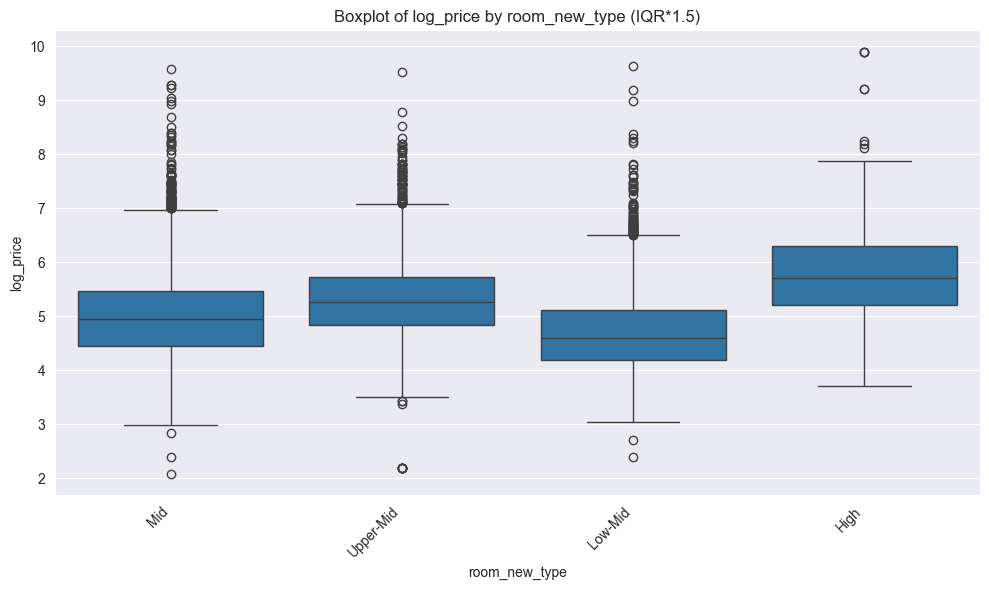

In [83]:
X = 'room_new_type'
y = 'log_price'
boxplot(df, X, y)

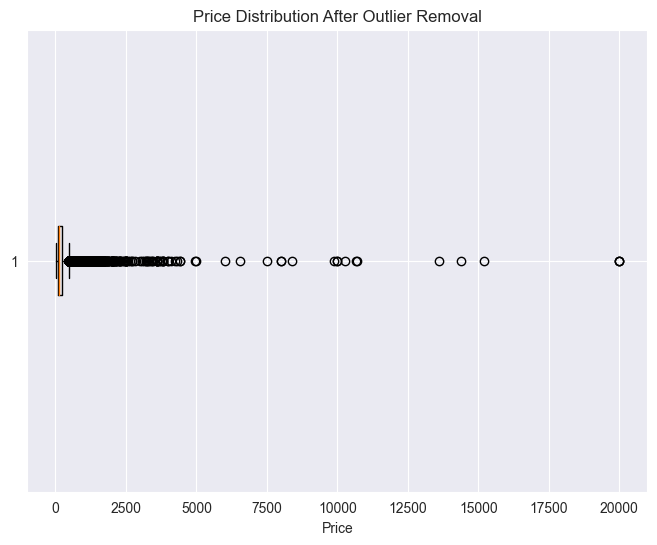

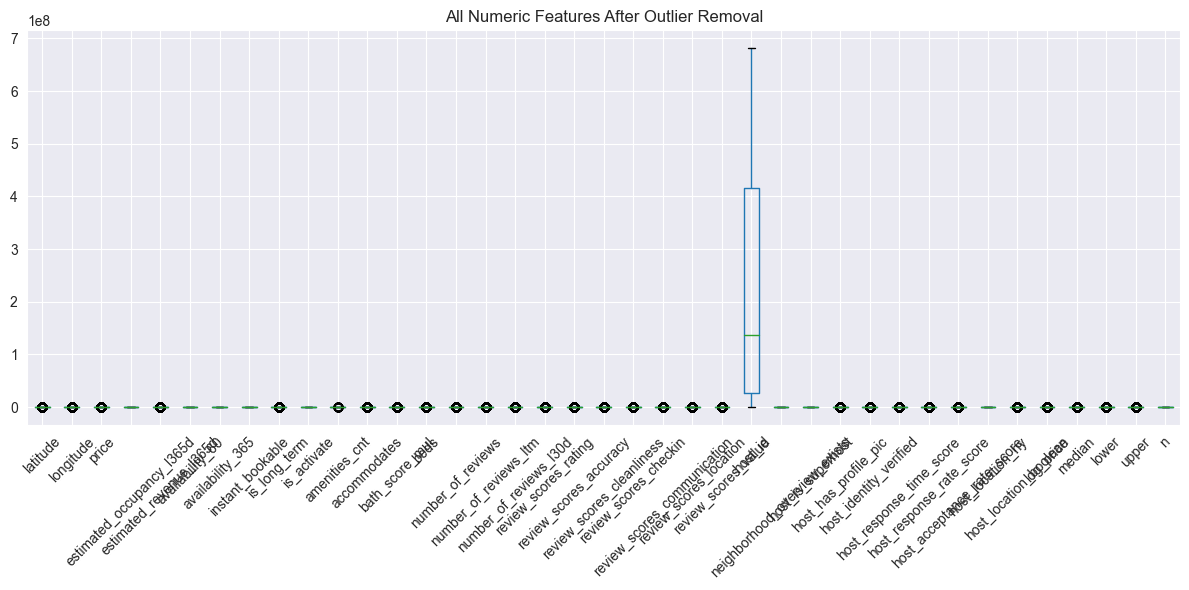

In [84]:
# 1) 단일 변수에 대한 박스플롯 (예: 'price')
plt.figure(figsize=(8, 6))
plt.boxplot(df['price'], vert=False)
plt.title('Price Distribution After Outlier Removal')
plt.xlabel('Price')
plt.show()

# 2) 모든 수치형 변수에 대한 박스플롯
numeric_cols = df.select_dtypes(include='number').columns.tolist()
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.xticks(rotation=45)
plt.title('All Numeric Features After Outlier Removal')
plt.tight_layout()
plt.show()

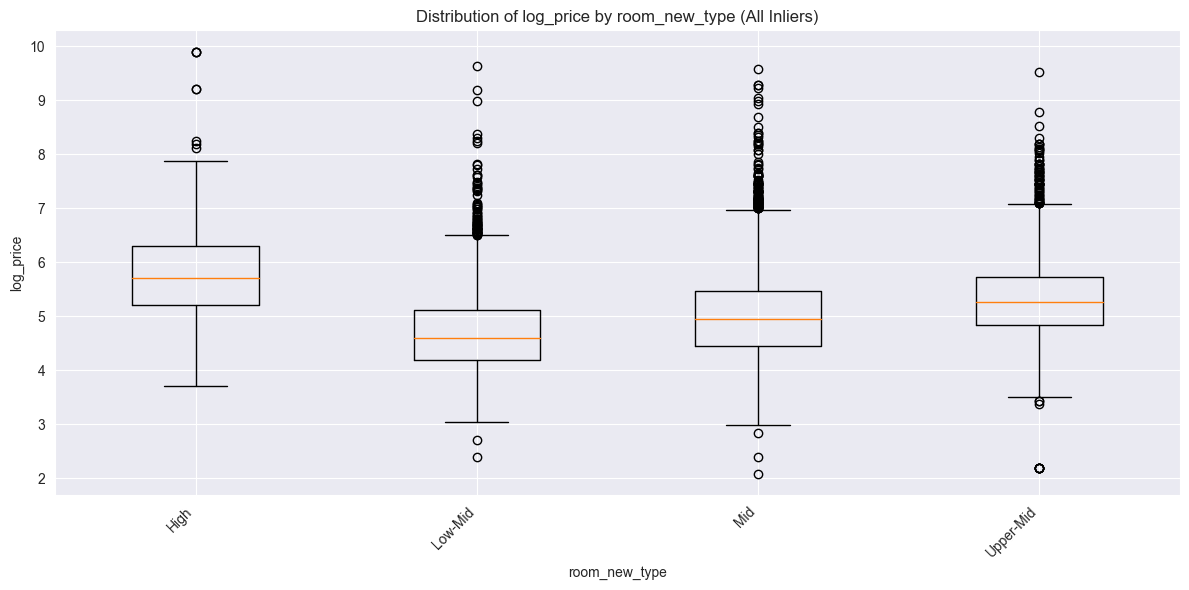

In [85]:
import matplotlib.pyplot as plt

# 그룹화 기준 컬럼과 값
X = 'room_new_type'
y = 'log_price'

# 1) Figure 생성
plt.figure(figsize=(12, 6))

# 2) 각 그룹별 데이터 리스트 생성
groups = sorted(df[X].unique())
data_to_plot = [df[df[X] == g][y] for g in groups]

# 3) 박스플롯 그리기
plt.boxplot(data_to_plot)
plt.xticks(range(1, len(groups) + 1), groups, rotation=45, ha='right')

# 4) 제목·축 레이블
plt.title('Distribution of log_price by room_new_type (All Inliers)')
plt.xlabel(X)
plt.ylabel(y)

# 5) 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()

In [86]:
    def test_normality(
        series: pd.Series,
        alpha: float = 0.05,
        verbose: bool = True
    ) -> Dict[str, Any]:

        """
        주어진 수치형 시리즈에 대해 여러 정규성 검정을 수행하고 결과를 딕셔너리로 반환합니다.

        Args:
            series: pandas Series, numeric 데이터 (NaN은 자동 제거)
            alpha: 유의수준 (p-value 비교 기준)
            verbose: True일 경우 결과 요약을 콘솔에 출력

        Returns:
            Dict[str, Any]:
                {
                    'n': 표본 수,
                    'skew': 왜도 (정규분포에서 0),
                    'kurt_excess': 초과 첨도 (정규분포에서 0),

                    'shapiro_stat': Shapiro-Wilk 통계량,
                    'shapiro_p' : Shapiro-Wilk p-value,
                    'dagostino_k2': D’Agostino K² 통계량,
                    'dagostino_p': D’Agostino K² p-value,
                    'jarque_bera': Jarque–Bera 통계량,
                    'jarque_bera_p': Jarque–Bera p-value,
                    'anderson_stat': Anderson–Darling 통계량,
                    'anderson_crit': {유의수준: 임계값, ...},
                    'lilliefors_stat': Lilliefors KS 통계량,
                    'lilliefors_p': Lilliefors p-value,

                    'practical_normal': 실무적 판정 (skew<0.5 & |kurt|<1)
                }
        """

        # 1. 데이터 전처리
        arr = pd.to_numeric(series, errors='coerce').dropna().values
        n = arr.size

        # 2. 기초 통계량
        skewness = stats.skew(arr, bias=False)
        kurt_excess = stats.kurtosis(arr, fisher=True, bias=False)

        # 3. 정규성 검정
        sh_stat, sh_p = stats.shapiro(arr)
        k2_stat, k2_p = stats.normaltest(arr)
        jb_stat, jb_p = stats.jarque_bera(arr)
        ad_res = stats.anderson(arr, dist='norm')
        ks_stat, ks_p = sm.stats.diagnostic.kstest_normal(arr)

        # 4. 실무적 판정
        practical = (abs(skewness) < 0.5) and (abs(kurt_excess) < 1)

        # 65 결과 집계
        results: Dict[str, Any] = {
            'n': n,
            'skew': skewness,
            'kurt_excess': kurt_excess,
            'shapiro_stat': sh_stat,
            'shapiro_p' : sh_p,
            'dagostino_k2': k2_stat,
            'dagostino_p': k2_p,
            'jarque_bera': jb_stat,
            'jarque_bera_p': jb_p,
            'anderson_stat': ad_res.statistic,
            'anderson_crit': dict(zip(ad_res.significance_level, ad_res.critical_values)),
            'lilliefors_stat': ks_stat,
            'lilliefors_p': ks_p,
            'practical_normal': practical
        }

        if verbose:
            print_normality(results, ad_res)

        # return results


    # 정규성 검정 결과 표 형식으로 정리
    def print_normality(
        results: Dict[str, Any],
        ad_res: Any,
        alpha: float = 0.05
    ) -> None:

        """
        정규성 검정 결과를 표 형식으로 출력합니다.

        Args:
            results: assess_normality()가 반환한 결과 딕셔너리
            ad_res: stats.anderson()의 반환 객체
            alpha: 유의수준 (default=0.05)
        """

        table = []
        # 1. 왜도, 첨도
        table.append([
            "Skew (왜도)",
            f"{results['skew']:.3f}",
            "-",
            "-"
        ])
        table.append([
            "Excess Kurtosis (첨도)",
            f"{results['kurt_excess']:.3f}",
            "-",
            "-"
        ])

        # 2. Shapiro - 표본 개수가 적을 땐, 적합하지 않다.
        table.append([
            "Shapiro-Wilk",
            f"{results['shapiro_stat']:.3f}",
            f"p={results['shapiro_p']:.3f}",
            "Reject" if results['shapiro_p'] < alpha else "Fail"
        ])

        # 3. D'Agostino K² - 표본 개수가 많을 때 적합하다.
        table.append([
            "D’Agostino K²",
            f"{results['dagostino_k2']:.3f}",
            f"p={results['dagostino_p']:.3f}",
            "Reject" if results['dagostino_p'] < alpha else "Fail"
        ])

        # 4. Jarque–Bera
        table.append([
            "Jarque–Bera",
            f"{results['jarque_bera']:.3f}",
            f"p={results['jarque_bera_p']:.3f}",
            "Reject" if results['jarque_bera_p'] < alpha else "Fail"
        ])

        # 5. Lilliefors KS
        table.append([
            "Lilliefors KS",
            f"{results['lilliefors_stat']:.3f}",
            f"p={results['lilliefors_p']:.3f}",
            "Reject" if results['lilliefors_p'] < alpha else "Fail"
        ])

        # 6. Anderson–Darling (여러 유의수준)
        for sl, cv in results['anderson_crit'].items():
            decision = "Reject" if results['anderson_stat'] > cv else "Fail"
            table.append([
                f"Anderson–Darling @{sl}%",
                f"{results['anderson_stat']:.3f}",
                f"crit={cv:.3f}",
                decision
            ])

        # 7. 실무적 판정
        table.append([
            "Practical Normal",
            "-",
            "-",
            str(results['practical_normal'])
        ])

        headers = ["검정항목", "통계량", "p-값 / 임계값", "판정"]
        print(f"\n[정규성 검정 결과]")
        print(tabulate(table, headers=headers, tablefmt="github"))

In [89]:
test_normality(df['log_price'])

| 검정항목                | 통계량   | p-값 / 임계값   | 판정   |
|-------------------------|----------|-----------------|--------|
| Skew (왜도)             | -0.022   | -               | -      |
| Excess Kurtosis (첨도)  | -0.472   | -               | -      |
| Shapiro-Wilk            | 0.993    | p=0.000         | Reject |
| D’Agostino K²           | 337.434  | p=0.000         | Reject |
| Jarque–Bera             | 192.372  | p=0.000         | Reject |
| Lilliefors KS           | 0.027    | p=0.001         | Reject |
| Anderson–Darling @15.0% | 31.624   | crit=0.576      | Reject |
| Anderson–Darling @10.0% | 31.624   | crit=0.656      | Reject |
| Anderson–Darling @5.0%  | 31.624   | crit=0.787      | Reject |
| Anderson–Darling @2.5%  | 31.624   | crit=0.918      | Reject |
| Anderson–Darling @1.0%  | 31.624   | crit=1.092      | Reject |
| Practical Normal        | -        | -               | True   |


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'n': 20560,
 'skew': -0.021929733401692075,
 'kurt_excess': -0.4716656149891514,
 'shapiro_stat': 0.9927374124526978,
 'shapiro_p': 1.3905691919380017e-30,
 'dagostino_k2': 337.43375963472516,
 'dagostino_p': 5.335683881157682e-74,
 'jarque_bera': 192.37215566293992,
 'jarque_bera_p': 1.686231359857327e-42,
 'anderson_stat': 31.624073381542985,
 'anderson_crit': {15.0: 0.576,
  10.0: 0.656,
  5.0: 0.787,
  2.5: 0.918,
  1.0: 1.092},
 'lilliefors_stat': 0.02685214315479828,
 'lilliefors_p': 0.0009999999999998899,
 'practical_normal': True}

In [88]:


csv_path = '/Airbnb_project_15/outlier_removed.csv'  # 여기에 absolute path

# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)

# 데이터 확인
df.head(2)

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,0,1,1,4.0,4,4,1,1,5.303305,mid
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,0,1,1,4.0,4,4,1,1,4.418841,upper-mid


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20560 entries, 36121 to 1366723228243064949
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_cleansed        20560 non-null  object 
 1   neighbourhood_group_cleansed  20560 non-null  object 
 2   latitude                      20560 non-null  float64
 3   longitude                     20560 non-null  float64
 4   price                         20560 non-null  float64
 5   estimated_occupancy_l365d     20560 non-null  int64  
 6   estimated_revenue_l365d       20560 non-null  float64
 7   availability_60               20560 non-null  int64  
 8   availability_365              20560 non-null  int64  
 9   instant_bookable              20560 non-null  int64  
 10  is_long_term                  20560 non-null  int64  
 11  is_activate                   20560 non-null  int64  
 12  amenities                     20560 non-null  o